<a href="https://colab.research.google.com/github/thisisSHAX/ML_Ops_Project-/blob/main/Autism_Screening_ONNX_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing required libraries

In [1]:
!pip install wandb
!pip install onnx
!pip install skl2onnx
!pip install onnxruntime
!pip install onnxmltools

     |████████████████████████████████| 1.7 MB 13.8 MB/s 
     |████████████████████████████████| 180 kB 66.3 MB/s 
     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 140 kB 80.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=6f5b8d2aed3abebb3ab9662152045fda4390040d9c0b1f82abd9bf6d5586224a
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ca1248f6138a1c97d1ce7f12a1228a4f8a724e66479e948ee74f3135941b552c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
     |████████████████████████████████| 12.7 MB 12.9 MB/s 
     |████████████████████████████████| 271 kB 13.8 MB/s 
     |███████████████████

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from skl2onnx import convert_sklearn, __version__, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  # noqa
import pprint
import os
import wandb

### Loading the dataset

In [3]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16Pd-BdhzNMzPqPWD6XEu_XFZaGrSqFUz')

In [4]:
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


### Identifying categorical and numerical variables

In [5]:
x_columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Age_Mons','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [6]:
cat_features = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [7]:
num_features = list(set(x_columns) - set(cat_features))

In [8]:
encoded_df = pd.get_dummies(df[x_columns], columns=cat_features, drop_first = True)

In [9]:
encoded_df.sample(5)

,Age_Mons,A1_1,A2_1,A3_1,A4_1,A5_1,A6_1,A7_1,A8_1,A9_1,A10_1,Sex_m,Ethnicity_Latino,Ethnicity_Native Indian,Ethnicity_Others,Ethnicity_Pacifica,Ethnicity_White European,Ethnicity_asian,Ethnicity_black,Ethnicity_middle eastern,Ethnicity_mixed,Ethnicity_south asian,Jaundice_yes,Family_mem_with_ASD_yes
72,21,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
575,35,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0
86,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
164,12,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
447,12,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [10]:
x_features = list(encoded_df.columns)

In [11]:
encoded_df.shape

(1054, 24)

### Data Splitting

In [12]:
X = encoded_df

In [13]:
Y = pd.get_dummies(df['Class/ASD Traits '], drop_first=True)

In [14]:
# Splitting after One - Hot Encoding
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_prod, Y_train, Y_prod = train_test_split(X_train, Y_train, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [15]:
# Splitting
train_X, test_X, train_Y, test_Y = train_test_split(df[x_columns], Y, test_size=0.2, random_state=1)

train_X, prod_X, train_Y, prod_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [16]:
Y_train

,Yes
462,1
852,1
1010,1
296,0
573,1
...,...
300,1
787,1
637,0
624,1


### Creating the pipeline for deployment

In [17]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', 
                                           OneHotEncoder(drop='first', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer, cat_features),
    ])

params = { "n_estimators": 400,
           "max_depth": 4,
           "objective": 'reg:squarederror' }

#xgb_regressor = XGBRegressor(**params)

clf1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ("classifier", LogisticRegression(random_state=100))])           

clf1.fit(train_X, train_Y)



#rmse = np.sqrt(mean_squared_error(test_Y, 
#                                  reg.predict(test_X)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age_Mons']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['A1', 'A2', 'A3', 'A4', 'A5',
                                                   'A6', 'A7', 'A8', 'A9',
                                                   'A10', 'Sex', 'Ethnicity',
                                                   'Jaundice',
                                                   'Fam

In [18]:
pred1_Y = clf1.predict(test_X)

Text(0.5, 257.44, 'Predicted label')

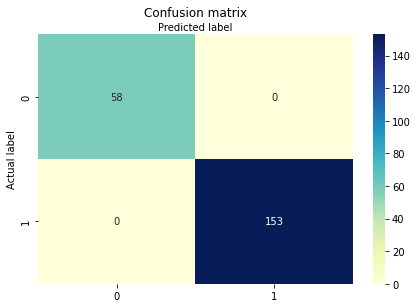

In [19]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(test_Y, pred1_Y)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
acc = metrics.accuracy_score(test_Y, pred1_Y)
prec = metrics.precision_score(test_Y, pred1_Y)
rec = metrics.recall_score(test_Y, pred1_Y)
f1 = metrics.f1_score(test_Y, pred1_Y)
spec = cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1])

In [21]:
print(acc)

1.0


### Creating the ONNX Graph

In [22]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = FloatTensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs


inputs = convert_dataframe_schema(train_X)

pprint.pprint(inputs)

[('A1', FloatTensorType(shape=[None, 1])),
 ('A2', FloatTensorType(shape=[None, 1])),
 ('A3', FloatTensorType(shape=[None, 1])),
 ('A4', FloatTensorType(shape=[None, 1])),
 ('A5', FloatTensorType(shape=[None, 1])),
 ('A6', FloatTensorType(shape=[None, 1])),
 ('A7', FloatTensorType(shape=[None, 1])),
 ('A8', FloatTensorType(shape=[None, 1])),
 ('A9', FloatTensorType(shape=[None, 1])),
 ('A10', FloatTensorType(shape=[None, 1])),
 ('Age_Mons', FloatTensorType(shape=[None, 1])),
 ('Sex', StringTensorType(shape=[None, 1])),
 ('Ethnicity', StringTensorType(shape=[None, 1])),
 ('Jaundice', StringTensorType(shape=[None, 1])),
 ('Family_mem_with_ASD', StringTensorType(shape=[None, 1]))]


In [23]:
#update_registered_converter(
#    LogisticRegression, 'LogisticRegressor',
#    calculate_linear_regressor_output_shapes, convert_xgboost)

### Converting the pipeline to ONNX format

In [24]:
model_onnx = convert_sklearn(
    clf1, 'pipeline_logreg',
    inputs)

### Storing the pipeline in a file

In [25]:
MODEL_DIR = "./autismscreeningprod"
MODEL_FILE_NAME = "autismscreening_logreg.onnx"

In [26]:
os.mkdir(MODEL_DIR)
# And save.
with open(MODEL_DIR + "/" + MODEL_FILE_NAME, "wb") as f:
    f.write(model_onnx.SerializeToString())

In [27]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Nov 25 10:10 .
drwxr-xr-x 1 root root 4096 Nov 25 09:59 ..
drwxr-xr-x 2 root root 4096 Nov 25 10:10 autismscreeningprod
drwxr-xr-x 4 root root 4096 Nov 18 14:35 .config
drwxr-xr-x 1 root root 4096 Nov 18 14:36 sample_data


### Uploading the pipeline to weights and biases for tracking

In [28]:
os.environ["WANDB_API_KEY"] = "26ff855733a63e9d999357d3e3bd1eb135cff5a5"

In [29]:
wandb.init(project='Autism_Screening_ONNX', 
           config=params, 
           tags = ['LogReg', 'OneHotEncoding'])

wandb.run.name = "LogRegProdModel"

wandb: Currently logged in as: thisisshax (use `wandb login --relogin` to force relogin)


In [30]:
#wandb.log( {"acc" : acc} )
wandb.log( {"Accuracy" : acc, 
              "Precision": prec,
              "Recall": rec,
              "F1 score" : f1} )

In [31]:
model_artifact = wandb.Artifact("LogReg_AutismScreening",
                                type = 'model',
                                description = 'LogReg Model for autism tracking prediction')

In [32]:
model_artifact.add_dir(MODEL_DIR)

wandb: Adding directory to artifact (./autismscreeningprod)... Done. 0.1s


In [33]:
wandb.run.log_artifact(model_artifact)

In [34]:
wandb.save()
wandb.finish()

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
Accuracy,1.0
F1 score,1.0
Precision,1.0
Recall,1.0


In [35]:
!zip -r wandb_onnx.zip /content/wandb

  adding: content/wandb/ (stored 0%)
  adding: content/wandb/debug-internal.log (deflated 89%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/ (stored 0%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/logs/ (stored 0%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/logs/debug-internal.log (deflated 89%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/logs/debug.log (deflated 82%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/ (stored 0%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/config.yaml (deflated 55%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/wandb-metadata.json (deflated 36%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/output.log (deflated 28%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/wandb-summary.json (deflated 31%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/files/requirements.txt (deflated 55%)
  adding: content/wandb/run-20211125_101255-1g7v22w2/tmp/ (stored 0%)
  